In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_msssim import MS_SSIM
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [16]:
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = "cpu"
# TODO: make sure to .to(device) the class later, and also set up gpu

# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0
# number of epochs
num_epochs = 100
# batch size for training
batch_size = 32
# height and width of input image
img_size = 64
# number of channels
nc0 = 1
nc1 = 4
nc2 = 8
nc3 = 16
# threshold
thresh = 0
# learning rate
lr = 0.002
# beta1 for Adam
beta1 = 0.5
# real label
real_label = 1.0
# fake label
fake_label = 0.0
# number of extra times to run the discriminator than the encdec per epoch
num_dis = 1
# coefficient of the discriminator loss in training
cof_dis = 1e-4

In [17]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [18]:
class FontDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.fontlist = pd.read_csv(csv_file, sep=' ')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fontlist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path1 = os.path.join(self.root_dir, "R/", f"{idx}.npy")
        img_path2 = os.path.join(self.root_dir, "B/", f"{idx}.npy")

        img1 = np.load(img_path1)
        img2 = np.load(img_path2)

        img1 = img1[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]
        img2 = img2[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        sample = {'c1': img1, 'c2': img2}

        return sample

In [19]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.conv1 = nn.Conv2d(nc0, nc1, 3, padding=1)
        self.conv2 = nn.Conv2d(nc1, nc2, 3, padding=1)
        self.conv3 = nn.Conv2d(nc2, nc2, 3, padding=1)
        self.conv2back = nn.Conv2d(nc2, nc1, 3, padding=1)
        self.conv1back = nn.Conv2d(nc1, nc0, 3, padding=1)
        
        self.conv1strided = nn.Conv2d(nc1, nc1, 3, stride=2, padding=1)
        self.conv2strided = nn.Conv2d(nc2, nc2, 3, stride=2, padding=1)

        self.deconv1 = nn.ConvTranspose2d(nc1, nc0, 3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(nc2, nc1, 3, padding=1)
        self.deconv1strided = nn.ConvTranspose2d(nc1, nc1, 3, stride=2, padding=1, output_padding=1)
        self.deconv2strided = nn.ConvTranspose2d(nc2, nc2, 3, stride=2, padding=1, output_padding=1)

        self.batchnorm0 = nn.BatchNorm2d(nc0)
        self.batchnorm1 = nn.BatchNorm2d(nc1)
        self.batchnorm2 = nn.BatchNorm2d(nc2)
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.threshold = nn.Threshold(thresh, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyrelu(x)
        x = self.conv2(x)
        x = self.leakyrelu(x)
        x, idx1 = self.pool(x)
        
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x, idx2 = self.pool(x)
        
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x, idx3 = self.pool(x)
        
        x = self.unpool(x, idx3)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx2)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx1)
        x = self.conv2back(x)
        x = self.leakyrelu(x)
        x = self.conv1back(x)
        x = self.leakyrelu(x)
        
        x = self.tanh(x)
        return x
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.batchnorm1(x)
#         x = self.leakyrelu(x)
#         #x, idx1 = self.pool(x)
#         x = self.conv1strided(x)

#         x = self.conv2(x)
#         x = self.batchnorm2(x)
#         x = self.leakyrelu(x)
#         #x, idx2 = self.pool(x)
#         x = self.conv2strided(x)

#         x = self.deconv2strided(x)
#         #x = self.unpool(x, idx2)
#         x = self.deconv2(x)
#         x = self.batchnorm1(x)
#         x = self.leakyrelu(x)

#         x = self.deconv1strided(x)
#         #x = self.unpool(x, idx1)
#         x = self.deconv1(x)
#         x = self.batchnorm0(x)
#         #x = self.relu(x)

#         #x = self.threshold(x)
#         x = self.tanh(x)
#         return x

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1 x img_size x img_size
            nn.Conv2d(nc0, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc1),
            nn.ReLU(inplace=True),
            # 4 x img_size/2 x img_size/2
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            
            # 8 x img_size/4 x img_size/4
            nn.Conv2d(nc2, nc3, 4, stride=2, padding=1),
            nn.BatchNorm2d(nc3),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc3, nc3, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc3, nc3, 3, padding=1),
            nn.ReLU(inplace=True),
            
            # 16 x img_size/8 x img_size/8
            nn.Flatten(),
            nn.Linear(nc3 * img_size // 8 * img_size // 8, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [21]:
def main():
    dataset = FontDataset(csv_file=fonts_csv, 
                        root_dir=dataroot, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(0.5, 0.5),
#                             AddGaussianNoise(0., 0.05),
                        ]))
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    
    encdec = EncoderDecoder()
    criterionED_l1 = nn.L1Loss()
    criterionED_ssim = MS_SSIM(win_size=3, data_range=1, size_average=True, channel=1)
    optimizerED = optim.Adam(encdec.parameters(), lr=lr)

    disc = Discriminator()
    criterionD = nn.BCELoss()
    optimizerD = optim.Adam(disc.parameters(), lr=lr)
    
    # training loop
    for epoch in range(num_epochs):
        running_lossD = 0.0
        running_loss_disc = 0.0
        running_loss_l1 = 0.0
        
        for it in range(num_dis):
            for i, data in enumerate(dataloader):
                disc.zero_grad()
                
                b_size = data['c2'].size(0)
                label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
                
                outputD = disc(data['c2']).view(-1)
                lossD_real = criterionD(outputD, label)
                lossD_real.backward()

                # all fake batch
                outputED = encdec(data['c1'])
                label.fill_(fake_label)
                outputD = disc(outputED.detach()).view(-1)
                lossD_fake = criterionD(outputD, label)
                lossD_fake.backward()

                lossD = lossD_real + lossD_fake
                optimizerD.step()
                            
        for i, data in enumerate(dataloader):
            ###########################
            # update disc
            ###########################
            disc.zero_grad()
            # all real batch
            b_size = data['c2'].size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            outputD = disc(data['c2']).view(-1)
            lossD_real = criterionD(outputD, label)
            lossD_real.backward()
            # all fake batch
            outputED = encdec(data['c1'])
            label.fill_(fake_label)
            outputD = disc(outputED.detach()).view(-1)
            lossD_fake = criterionD(outputD, label)
            lossD_fake.backward()

            lossD = lossD_real + lossD_fake
            optimizerD.step()

            ###########################
            # update encdec
            ###########################
            encdec.zero_grad()
            # rerun disc
            label.fill_(real_label)
            outputD = disc(outputED).view(-1)
            lossED_disc = criterionD(outputD, label)
            # run encdec
            lossED_l1 = criterionED_l1(outputED, data['c2'])
            outputED_norm = (outputED + 1) / 2
            datac2_norm = (data['c2'] + 1) / 2
            lossED_ssim = 1 - criterionED_ssim(outputED_norm, datac2_norm)

            lossED = cof_dis * lossED_disc + 0.16 * lossED_l1 + 0.84 * lossED_ssim
            lossED.backward()
            optimizerED.step()
    
            running_lossD += lossD.item()
            running_loss_disc += lossED_disc.item()
            running_loss_l1 += lossED_l1.item()
            if i % 50 == 49:
                print(f"Epoch {epoch+1}, Iteration {i+1}, Loss D {running_lossD}, Loss Disc {running_loss_disc}, Loss L1 {running_loss_l1}")
                running_lossD = 0.0
                running_loss_disc = 0.0
                running_loss_l1 = 0.0
                
                fig = plt.figure(figsize=(8, 8))
                fig.add_subplot(1, 2, 1)
                plt.imshow(data['c1'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                fig.add_subplot(1, 2, 2)
                plt.imshow(outputED[0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                plt.show()
    
    torch.save(encdec.state_dict(), 'encdec.pt')
    print("Done")

Epoch 1, Iteration 50, Loss D 69.44170902160454, Loss Disc 1312.898205280304, Loss L1 44.65979665517807


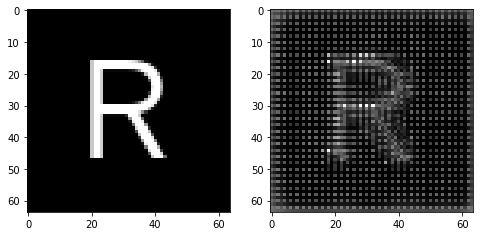

Epoch 1, Iteration 100, Loss D 38.92371949739754, Loss Disc 181.84338679909706, Loss L1 9.172291219234467


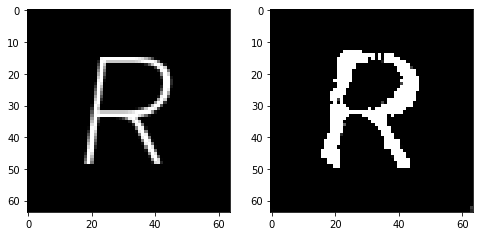

Epoch 2, Iteration 50, Loss D 22.946305928751826, Loss Disc 153.96256637573242, Loss L1 7.390892431139946


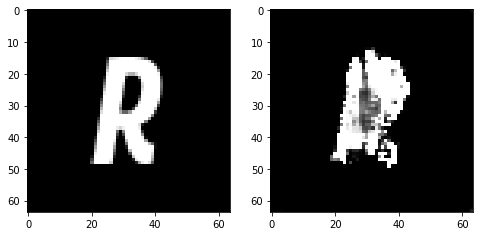

Epoch 2, Iteration 100, Loss D 11.2360385148786, Loss Disc 190.9677209854126, Loss L1 7.618542179465294


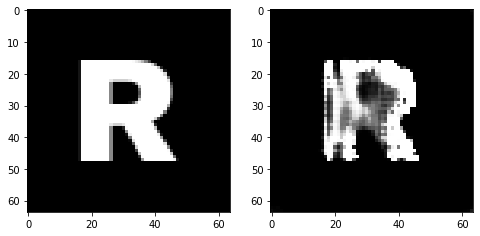

Epoch 3, Iteration 50, Loss D 0.9319357603962999, Loss Disc 375.21453499794006, Loss L1 6.502345219254494


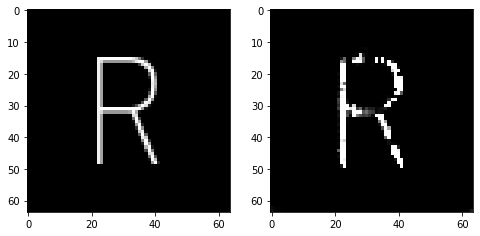

Epoch 3, Iteration 100, Loss D 7.955880718451226, Loss Disc 338.6083867549896, Loss L1 6.300854921340942


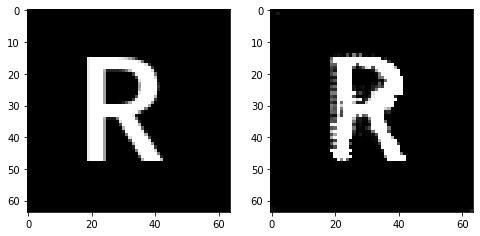

Epoch 4, Iteration 50, Loss D 1.666715150437085, Loss Disc 476.28410148620605, Loss L1 6.120965391397476


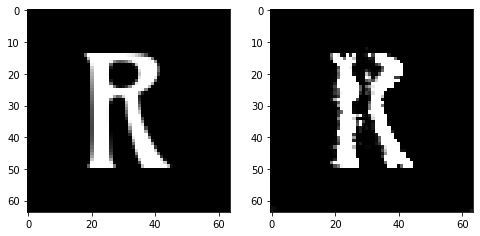

Epoch 4, Iteration 100, Loss D 0.10841829610581044, Loss Disc 466.6247763633728, Loss L1 5.794184036552906


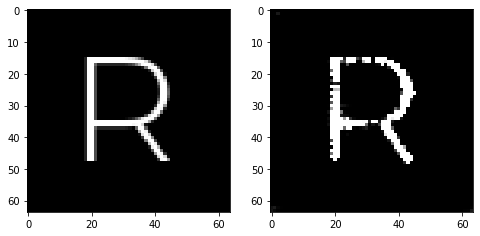

Epoch 5, Iteration 50, Loss D 2.626335146022029, Loss Disc 310.6923121213913, Loss L1 5.764685124158859


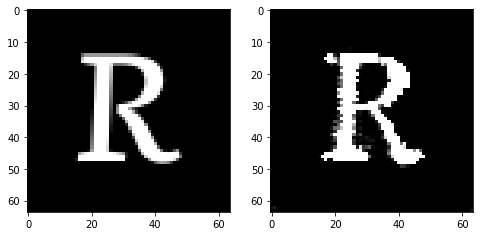

Epoch 5, Iteration 100, Loss D 0.08840067419805564, Loss Disc 468.52886867523193, Loss L1 5.666630186140537


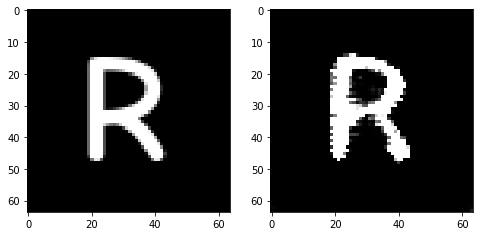

Epoch 6, Iteration 50, Loss D 0.060219829370907973, Loss Disc 531.6628770828247, Loss L1 5.6037314757704735


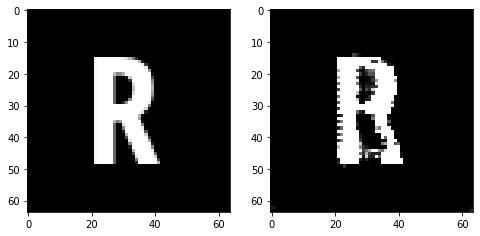

Epoch 6, Iteration 100, Loss D 0.0682169390420313, Loss Disc 491.51213693618774, Loss L1 5.420136980712414


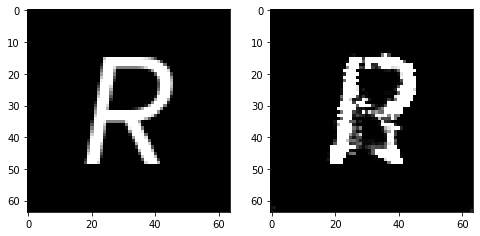

Epoch 7, Iteration 50, Loss D 0.01027394277480198, Loss Disc 534.3754234313965, Loss L1 5.20174764841795


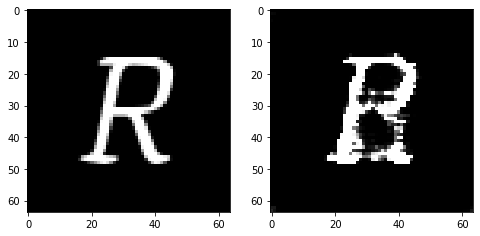

Epoch 7, Iteration 100, Loss D 0.025008152188092936, Loss Disc 517.1805667877197, Loss L1 4.9354525581002235


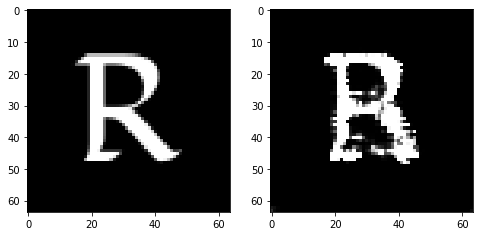

Epoch 8, Iteration 50, Loss D 1.627270273580507, Loss Disc 472.7616276741028, Loss L1 4.837787076830864


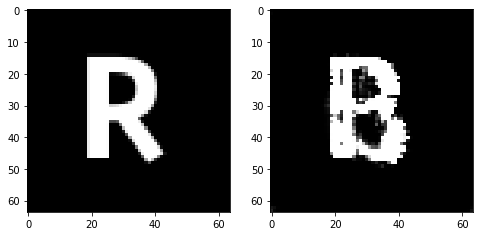

Epoch 8, Iteration 100, Loss D 0.03956856553668331, Loss Disc 572.6076145172119, Loss L1 4.67817996442318


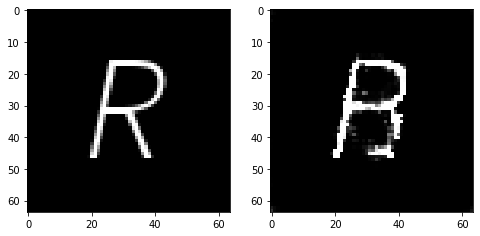

Epoch 9, Iteration 50, Loss D 0.00494855575470865, Loss Disc 621.7652568817139, Loss L1 4.611462377011776


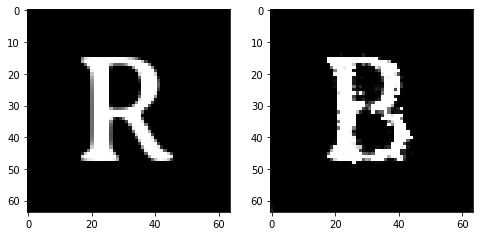

Epoch 9, Iteration 100, Loss D 0.006406905896483295, Loss Disc 604.4077253341675, Loss L1 4.480091869831085


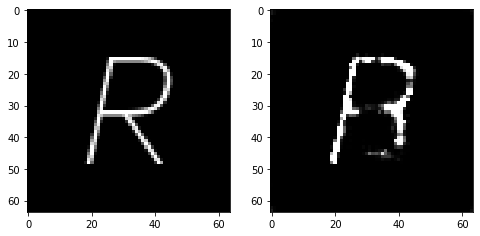

Epoch 10, Iteration 50, Loss D 362.2234117984772, Loss Disc 40.275176594079085, Loss L1 4.415791869163513


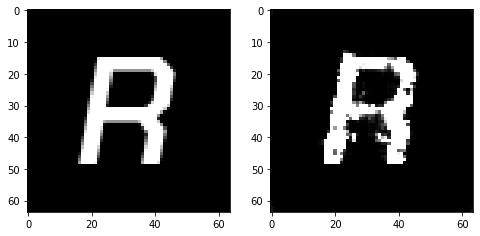

Epoch 10, Iteration 100, Loss D 48.20652195811272, Loss Disc 88.80021291971207, Loss L1 4.332774609327316


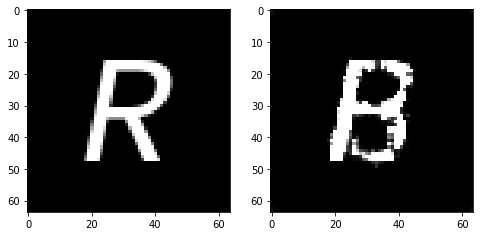

Epoch 11, Iteration 50, Loss D 11.55601404979825, Loss Disc 301.9734137058258, Loss L1 4.3125880137085915


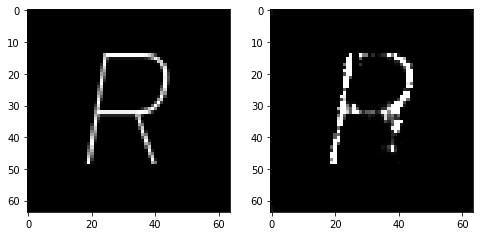

Epoch 11, Iteration 100, Loss D 9.881194990128279, Loss Disc 309.5254120826721, Loss L1 4.256648443639278


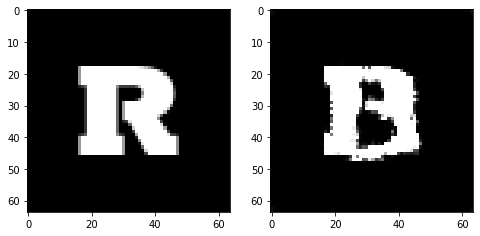

Epoch 12, Iteration 50, Loss D 2.2872277244459838, Loss Disc 446.67446517944336, Loss L1 4.289276115596294


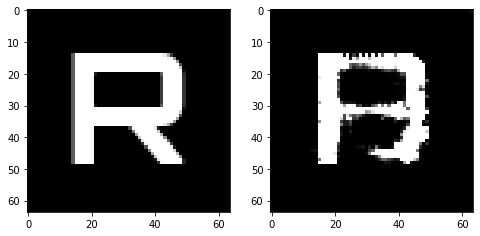

Epoch 12, Iteration 100, Loss D 1.8087203681934625, Loss Disc 488.5970301628113, Loss L1 4.132516533136368


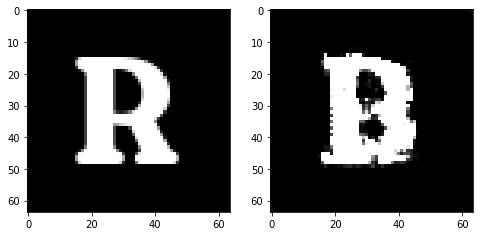

Epoch 13, Iteration 50, Loss D 0.268023129508947, Loss Disc 644.7700366973877, Loss L1 4.114641532301903


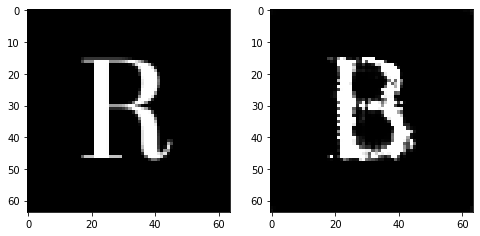

Epoch 13, Iteration 100, Loss D 0.26888687910104636, Loss Disc 546.232328414917, Loss L1 4.151170946657658


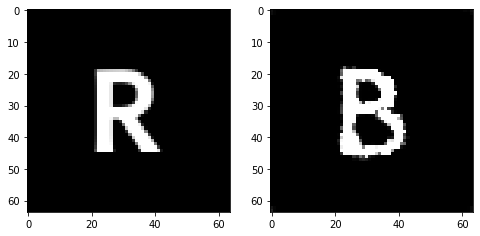

Epoch 14, Iteration 50, Loss D 0.6741216501413874, Loss Disc 681.7023830413818, Loss L1 4.065263159573078


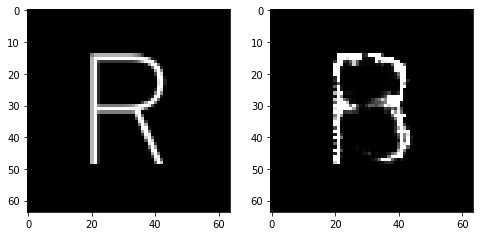

Epoch 14, Iteration 100, Loss D 0.2004325140551373, Loss Disc 640.2816581726074, Loss L1 4.0553184524178505


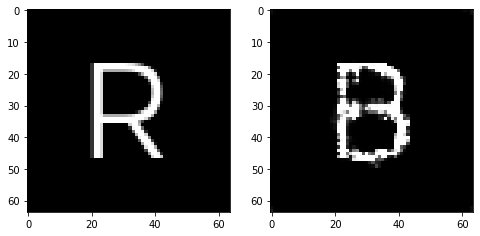

Epoch 15, Iteration 50, Loss D 0.024075715520666563, Loss Disc 694.6223230361938, Loss L1 4.04396165907383


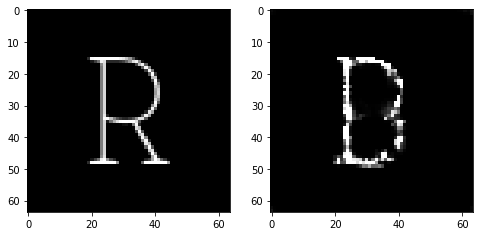

Epoch 15, Iteration 100, Loss D 0.11099932248907862, Loss Disc 690.2769994735718, Loss L1 3.9866651594638824


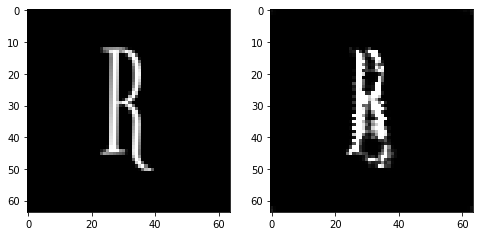

Epoch 16, Iteration 50, Loss D 0.4509333805690403, Loss Disc 513.2062430381775, Loss L1 4.054325230419636


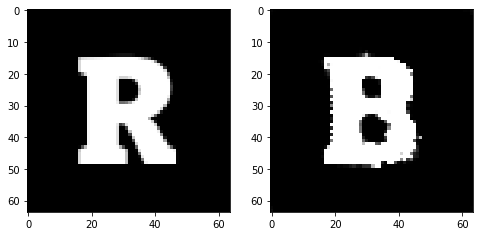

Epoch 16, Iteration 100, Loss D 3.070890324903303, Loss Disc 505.8868227005005, Loss L1 3.899971082806587


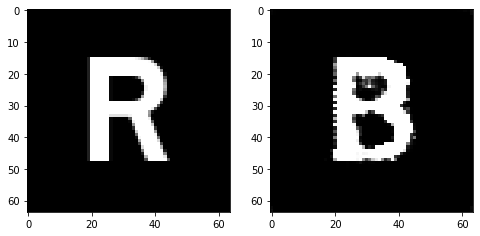

Epoch 17, Iteration 50, Loss D 0.031702161777502624, Loss Disc 569.8619794845581, Loss L1 3.998293161392212


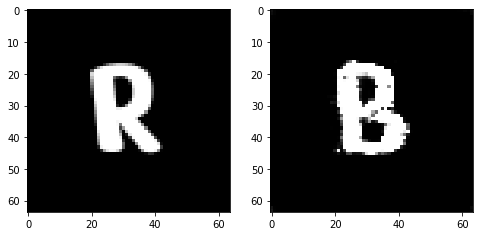

Epoch 17, Iteration 100, Loss D 0.03576616144073341, Loss Disc 588.8908834457397, Loss L1 3.9242757484316826


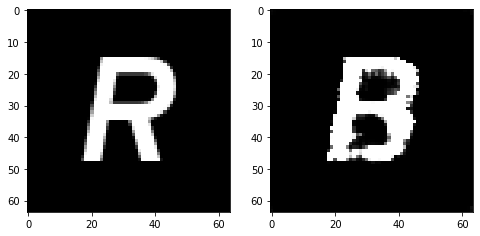

Epoch 18, Iteration 50, Loss D 0.1178606133616995, Loss Disc 418.5322985649109, Loss L1 3.9121128767728806


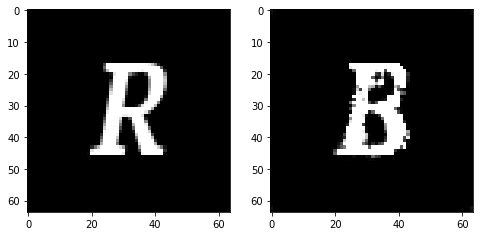

Epoch 18, Iteration 100, Loss D 0.09092304576188326, Loss Disc 452.5478410720825, Loss L1 3.945413276553154


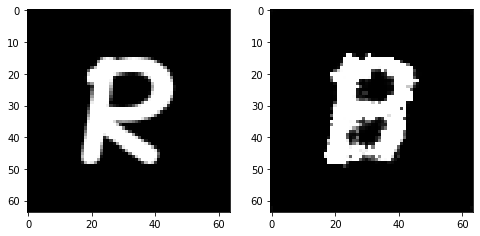

In [ ]:
main()

In [13]:
# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0

dataset = FontDataset(csv_file=fonts_csv, 
                      root_dir=dataroot, 
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(0.5, 0.5),
                      ]))

In [14]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=workers)

encdec = EncoderDecoder()
encdec.load_state_dict(torch.load('encdec.pt'))
encdec.eval()

EncoderDecoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2back): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1back): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1strided): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2strided): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1strided): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2strided): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (batchnorm0): BatchNorm2d(1, ep

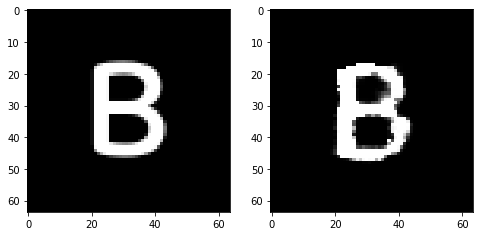

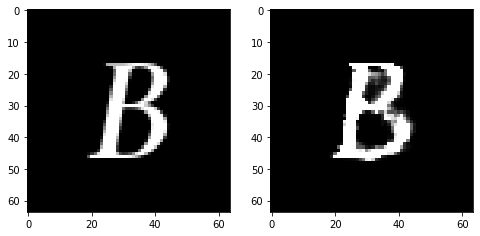

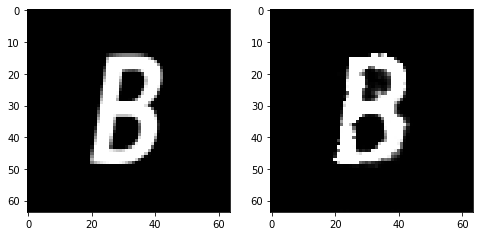

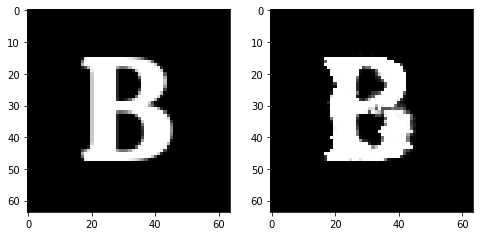

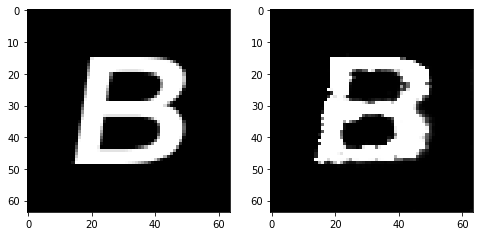

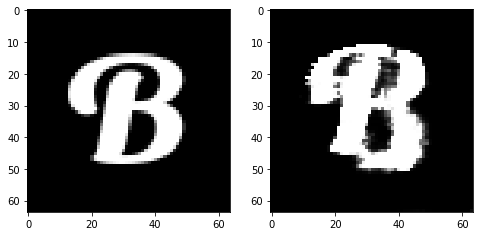

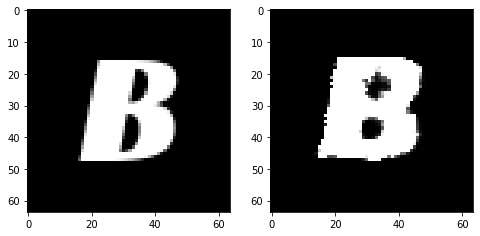

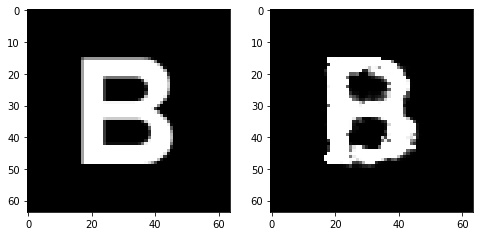

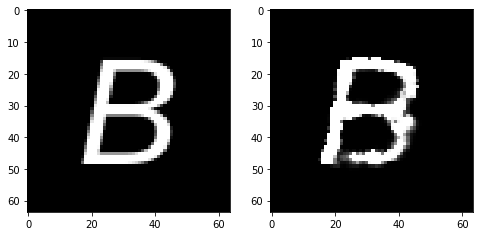

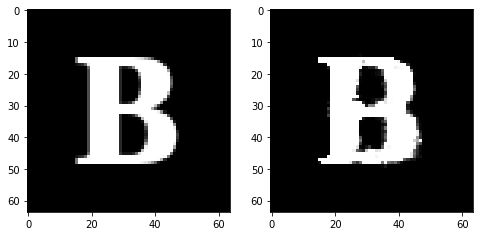

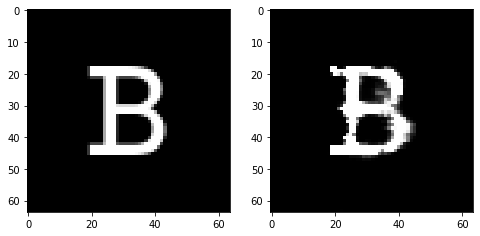

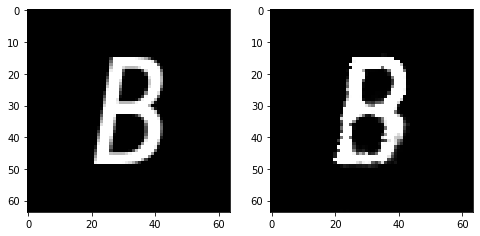

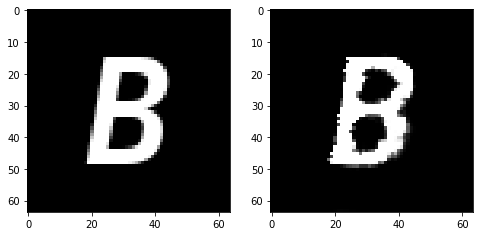

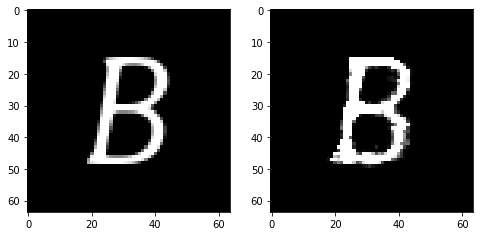

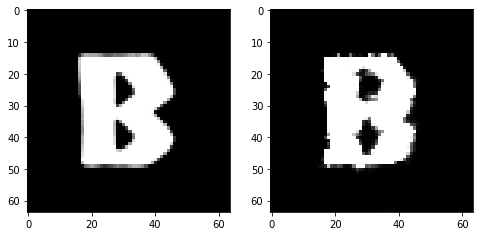

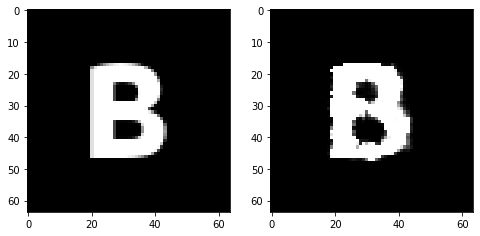

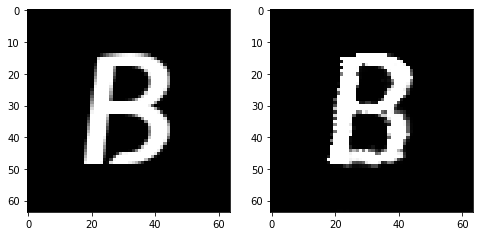

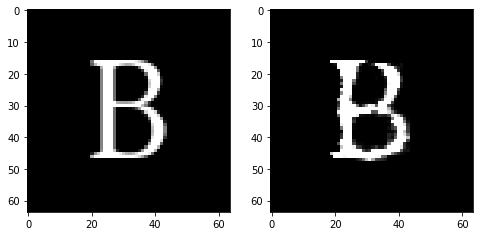

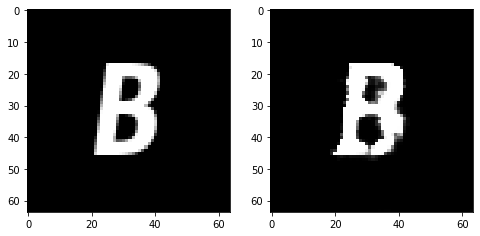

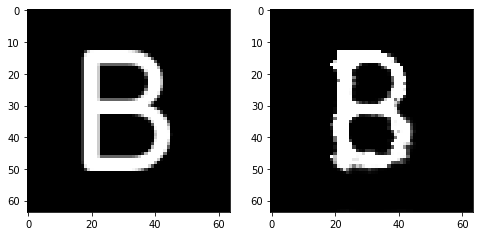

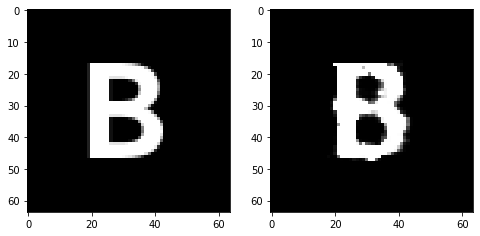

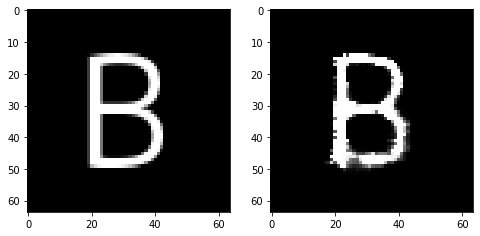

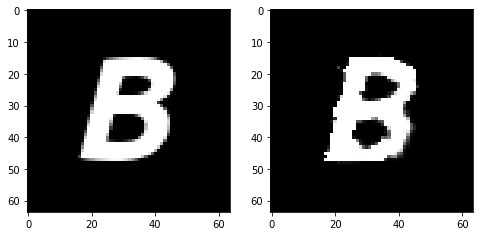

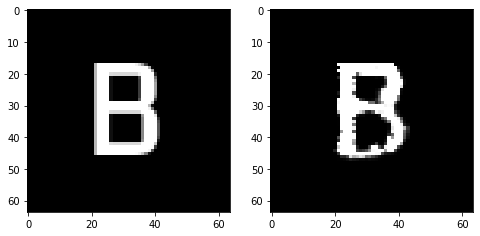

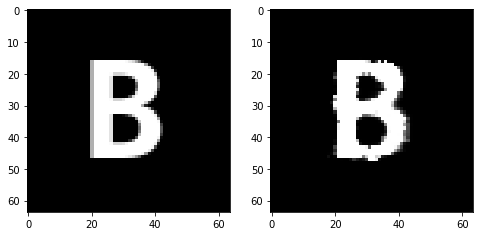

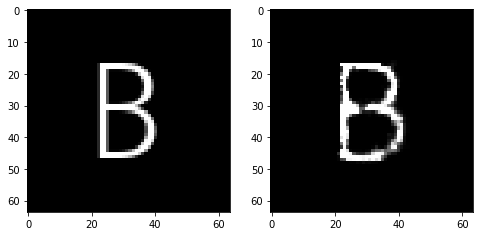

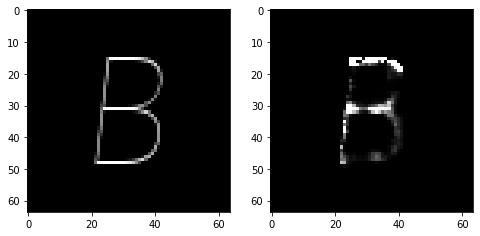

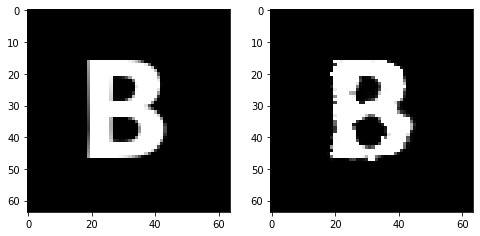

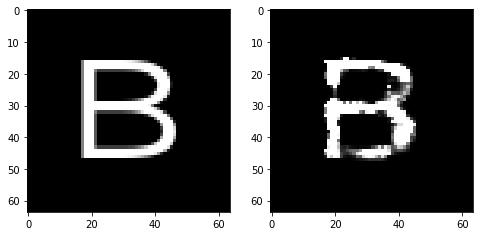

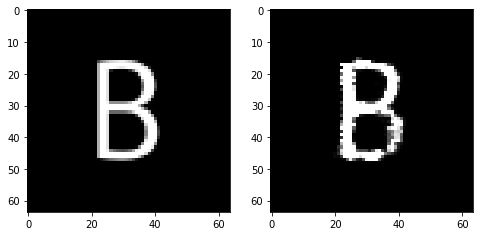

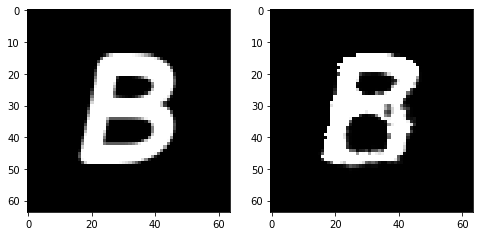

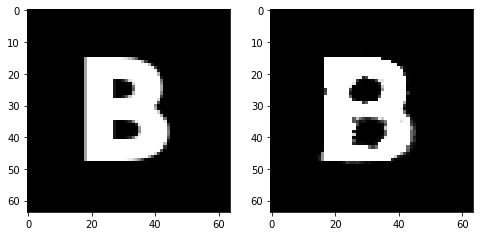

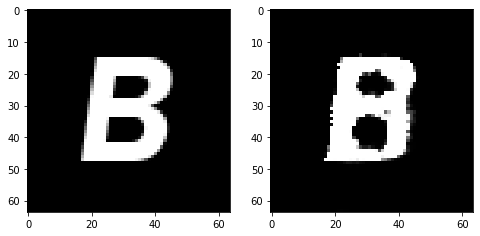

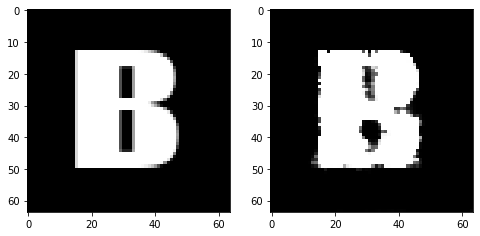

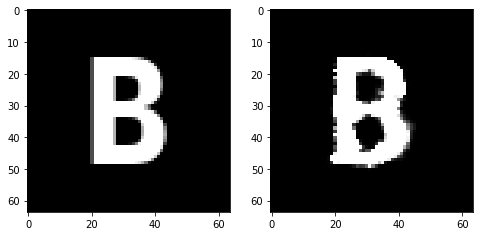

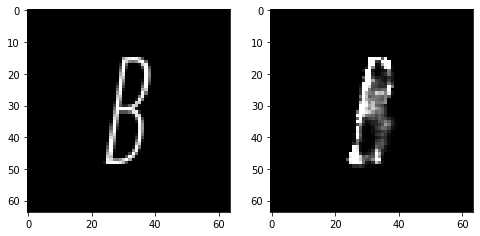

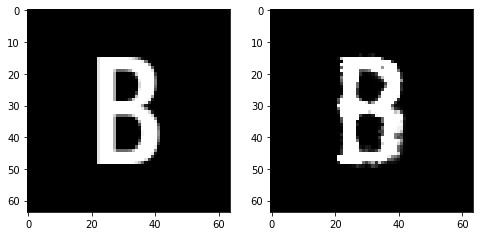

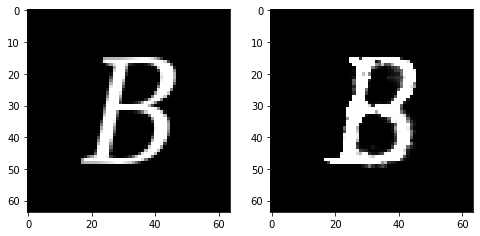

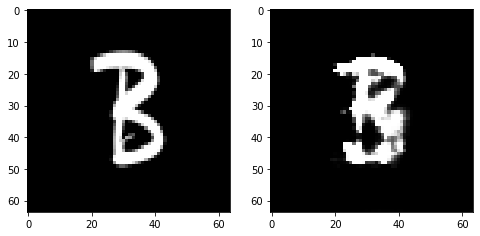

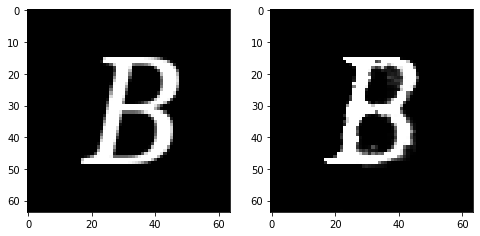

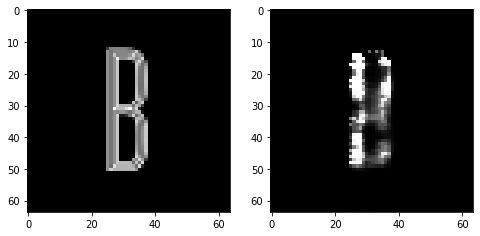

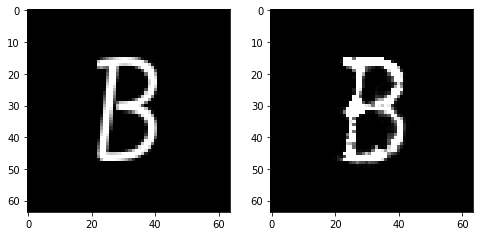

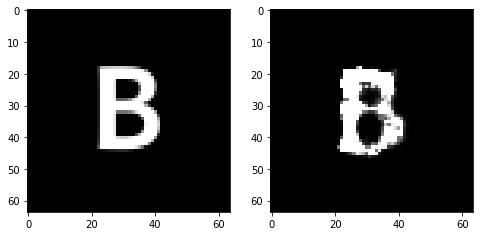

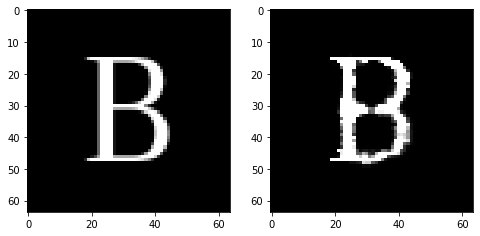

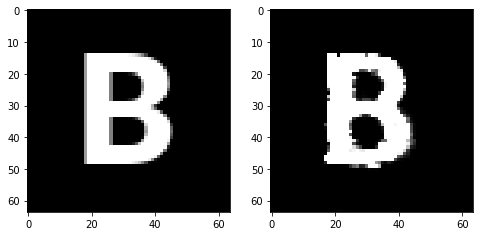

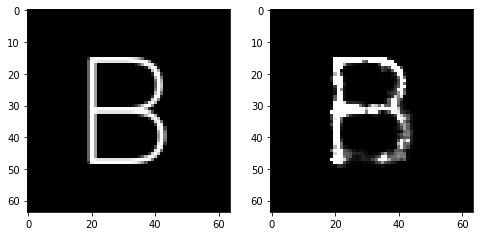

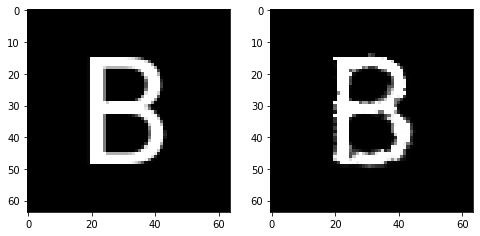

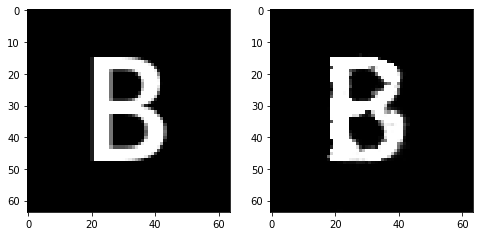

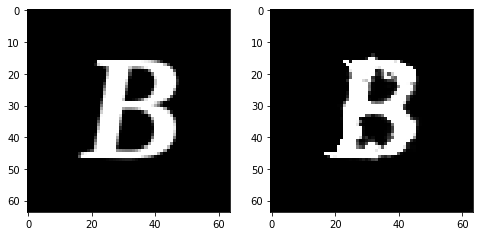

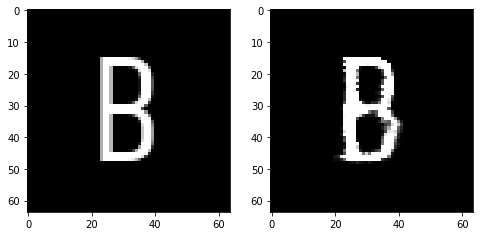

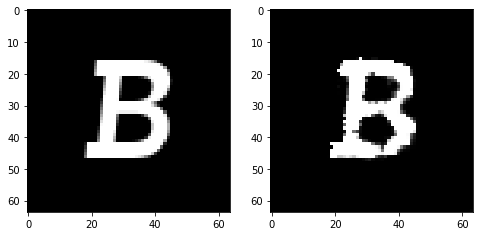

In [15]:
for i, data in enumerate(dataloader):
    if i > 50:
        break
    fig = plt.figure(figsize=(8, 8))
    output = encdec(data['c1'])
    fig.add_subplot(1, 2, 1)
    plt.imshow(data['c2'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(output[0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    plt.show()

3240.npy
./fonts/SometypeMono-Regular.ttf


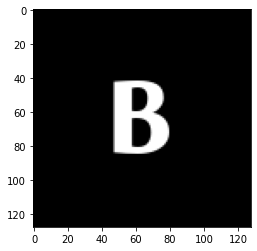

1952.npy
./fonts/AlegreyaSC-Italic.ttf


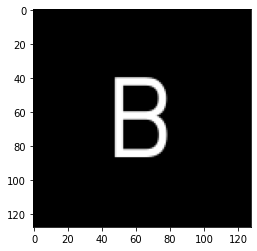

616.npy
./fonts/Heebo-Medium.ttf


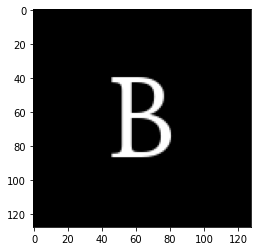

1418.npy
./fonts/RedHatDisplay-Black.ttf


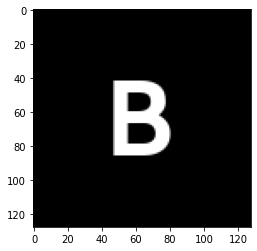

3171.npy
./fonts/BarlowCondensed-LightItalic.ttf


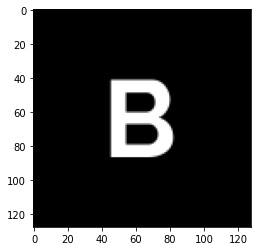

1139.npy
./fonts/CabinSketch-Bold.ttf


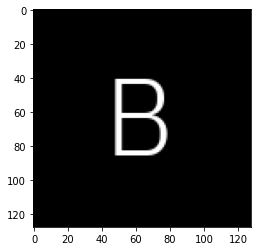

1918.npy
./fonts/Mina-Regular.ttf


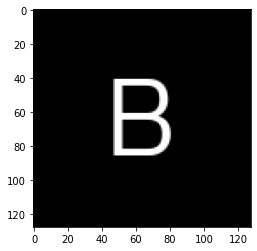

3199.npy
./fonts/Sunflower-Medium.ttf


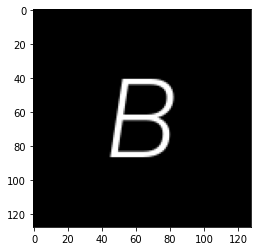

80.npy
./fonts/LibreFranklin-Italic[wght].ttf


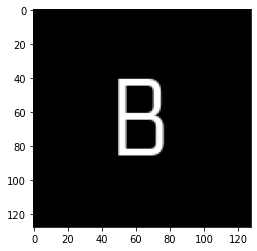

3749.npy
./fonts/ZillaSlab-Regular.ttf


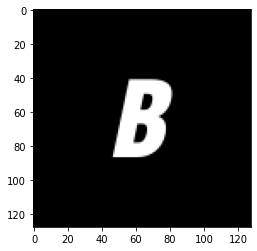

1428.npy
./fonts/CrimsonText-Regular.ttf


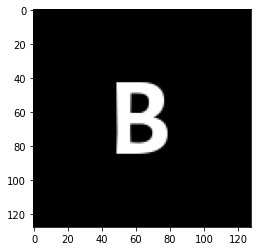

1366.npy
./fonts/CabinSketch-Regular.ttf


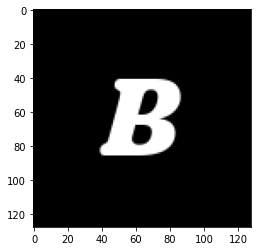

1280.npy
./fonts/Stylish-Regular.ttf


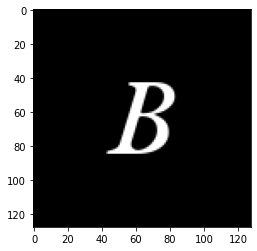

745.npy
./fonts/Radley-Italic.ttf


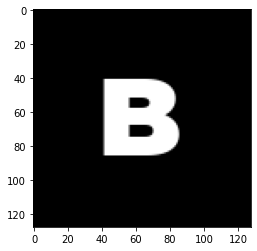

2368.npy
./fonts/Trispace-ExtraLight.ttf


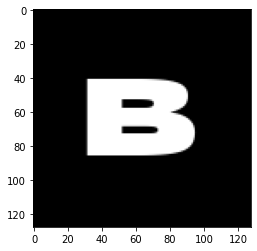

2289.npy
./fonts/Inconsolata-ExtraLight.ttf


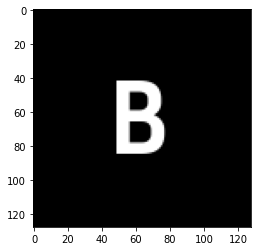

451.npy
./fonts/GothicA1-Black.ttf


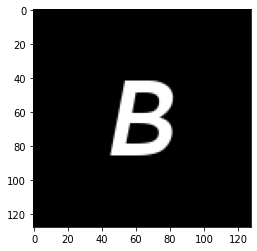

620.npy
./fonts/Rokkitt-Regular.ttf


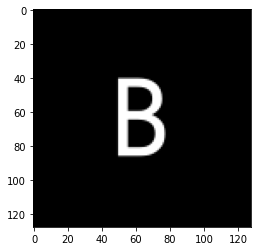

3626.npy
./fonts/SeoulHangangCondensed-ExtraBold.ttf


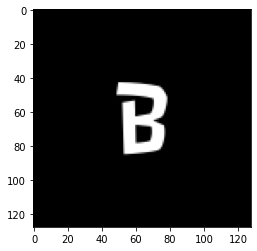

230.npy
./fonts/Rubik[wght].ttf


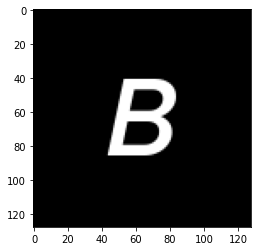

3398.npy
./fonts/Thasadith-BoldItalic.ttf


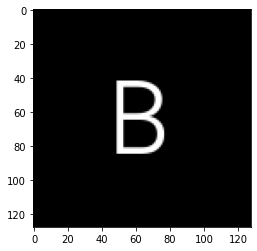

513.npy
./fonts/GeoramaExtraExpanded-SemiBold.ttf


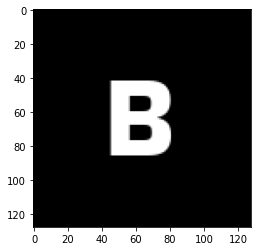

3053.npy
./fonts/LilyScriptOne-Regular.ttf


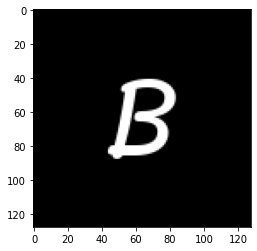

1879.npy
./fonts/BioRhyme-ExtraBold.ttf


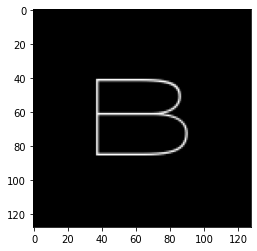

778.npy
./fonts/Lato-LightItalic.ttf


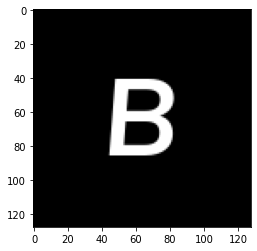

3588.npy
./fonts/Livvic-Medium.ttf


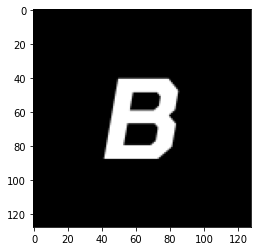

2327.npy
./fonts/GeoramaExtraExpanded-Black.ttf


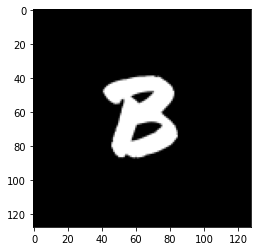

1529.npy
./fonts/Barlow-Bold.ttf


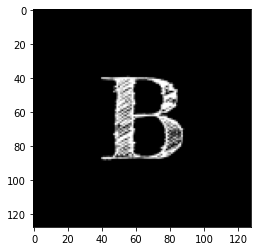

3338.npy
./fonts/Amaranth-Italic.ttf


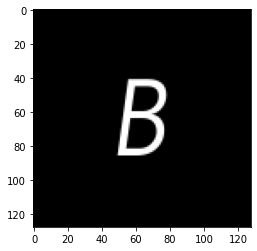

557.npy
./fonts/ExpletusSans-SemiBold.ttf


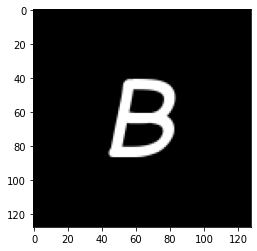

69.npy
./fonts/Petrona-LightItalic.ttf


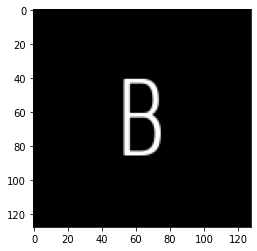

991.npy
./fonts/Sarabun-ExtraBoldItalic.ttf


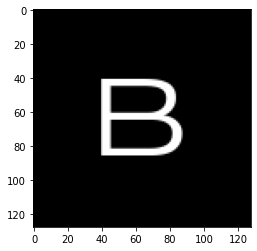

2768.npy
./fonts/Ubuntu-Bold.ttf


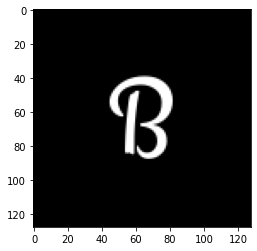

2789.npy
./fonts/HindMadurai-Bold.ttf


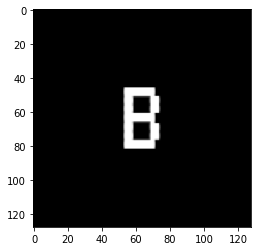

3331.npy
./fonts/AsapCondensed-Regular.ttf


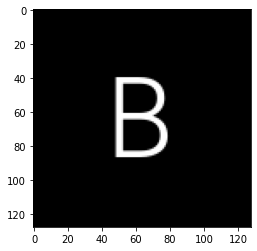

1885.npy
./fonts/Arvo-Regular.ttf


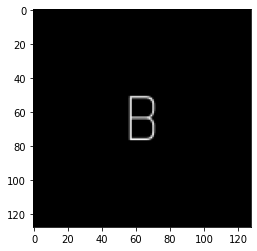

1654.npy
./fonts/RobotoMono-Italic.ttf


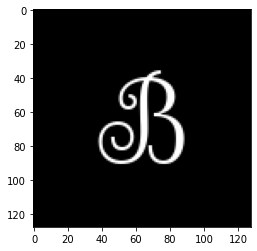

3783.npy
./fonts/GeoramaExtraExpanded-Italic.ttf


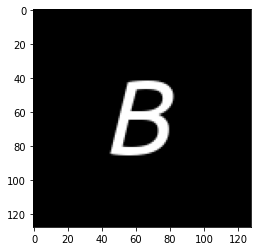

634.npy
./fonts/NanumMyeongjo-ExtraBold.ttf


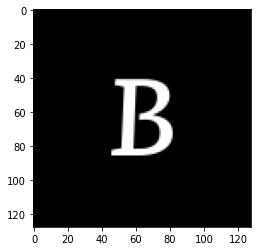

3003.npy
./fonts/GeoramaCondensed-SemiBold.ttf


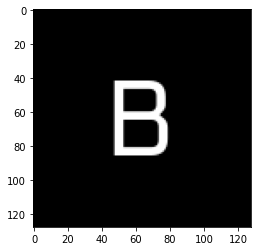

1506.npy
./fonts/Enriqueta-Bold.ttf


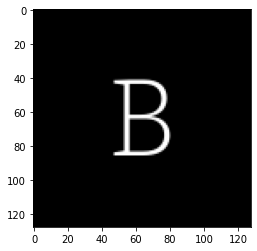

3009.npy
./fonts/AlegreyaSC-Regular.ttf


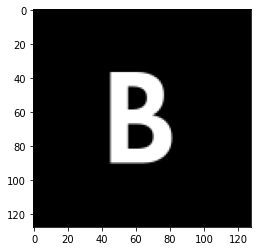

275.npy
./fonts/Radley-Regular.ttf


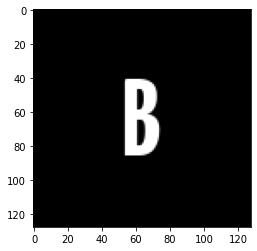

2049.npy
./fonts/IBMPlexMono-Light.ttf


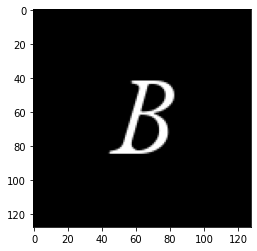

1522.npy
./fonts/IBMPlexSansCondensed-Italic.ttf


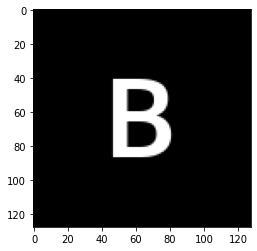

402.npy
./fonts/Kodchasan-ExtraLight.ttf


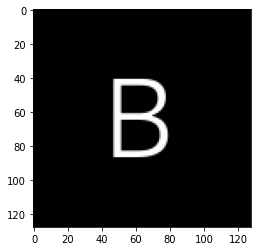

1802.npy
./fonts/TurretRoad-ExtraBold.ttf


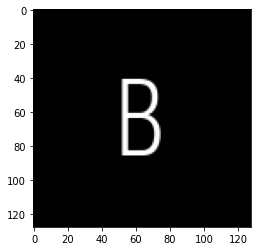

2265.npy
./fonts/ZCOOLQingKeHuangYou-Regular.ttf


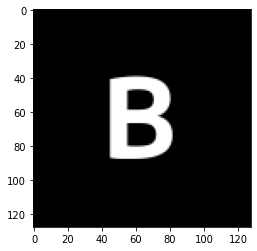

3932.npy


KeyError: 3932

In [57]:
font_set = pd.read_csv('fonts.csv', sep=' ', header=None)

letter_dir = './images/B'
for file in os.listdir(letter_dir):
    print(file)
    img = np.load(os.path.join(letter_dir, file))
    
    num = int(file.split('.')[0])
    font_name = font_set[1][num]
    print(font_name)
    
    plt.imshow(img, cmap='gray')
    plt.show()